<a href="https://colab.research.google.com/github/entanglement-nak/portfolio-nak/blob/main/%E3%83%9D%E3%83%BC%E3%83%88%E3%83%95%E3%82%A9%E3%83%AA%E3%82%AA%E8%AA%B2%E9%A1%8C%E3%80%80%E3%83%A9%E3%83%B3%E3%83%80%E3%83%A0%E3%83%95%E3%82%A9%E3%83%AC%E3%82%B9%E3%83%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# データパス
train_path = r"/content/drive/MyDrive/Wafer/Wafer_TRAIN.xlsx"

test_path = r"/content/drive/MyDrive/Wafer/Wafer_TEST.xlsx"

In [23]:
train_df = pd.read_excel(train_path, header=None)

test_df = pd.read_excel(test_path, header=None)

In [24]:
# トレインデータとテストデータを縦に統合（スタック）
combined_data = pd.concat([train_df, test_df], axis=0)

In [25]:
# データを特徴量(X)とターゲット(y)に分割
X = combined_data.drop(combined_data.columns[0], axis=1)
y = combined_data[combined_data.columns[0]]

In [26]:
# データを訓練用とテスト用に7:3の比率で分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
# 訓練データ内で正常と異常のクラスを分離し、異常クラスのアップサンプリングを行う
df_train = pd.concat([X_train, y_train], axis=1)
df_normal_train = df_train[df_train[df_train.columns[-1]] == 1]
df_anomaly_train = df_train[df_train[df_train.columns[-1]] == -1]

df_anomaly_upsampled = resample(df_anomaly_train, replace=True, n_samples=len(df_normal_train), random_state=123)
df_upsampled_train = pd.concat([df_normal_train, df_anomaly_upsampled])

In [28]:
# アップサンプリングされたデータを特徴量(X)とターゲット(y)に分割
X_train_upsampled = df_upsampled_train.drop(df_upsampled_train.columns[-1], axis=1)
y_train_upsampled = df_upsampled_train[df_upsampled_train.columns[-1]]

In [29]:
# ランダムフォレスト分類器の初期化（ハイパーパラメータを調整）
random_forest = RandomForestClassifier(n_estimators=100, max_depth=6, min_samples_split=4, min_samples_leaf=3)

In [30]:
# 訓練データでモデルを訓練
random_forest.fit(X_train_upsampled, y_train_upsampled)

RandomForestClassifier(max_depth=6, min_samples_leaf=3, min_samples_split=4)

In [31]:
# テストデータでの予測
y_pred = random_forest.predict(X_test)

In [32]:
# モデルの評価
accuracy = accuracy_score(y_test, y_pred)
MCC = matthews_corrcoef(y_test, y_pred)
F1 = f1_score(y_test, y_pred, average='binary')
report = classification_report(y_test, y_pred)

print("\n")
print(f"正解率：{accuracy}")
print(f"MCC：{MCC}")
print(f"F1：{F1}")



正解率：0.9986046511627907
MCC：0.992356503372486
F1：0.9992238033635188


↓↓過学習していないかチェックを行う。↓↓

In [33]:
from sklearn.metrics import accuracy_score

トレーニングデータとテストデータによる性能評価:

In [34]:
# ランダムフォレストモデルを初期化
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# モデルをトレーニングデータで学習
rf_model.fit(X_train_upsampled, y_train_upsampled)

# トレーニングデータとテストデータでの性能評価
train_accuracy = accuracy_score(y_train_upsampled, rf_model.predict(X_train_upsampled))
test_accuracy = accuracy_score(y_test, rf_model.predict(X_test))
train_F1 = f1_score(y_train_upsampled, rf_model.predict(X_train_upsampled), average='binary')
test_F1 = f1_score(y_test, rf_model.predict(X_test), average='binary')

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)
print("\n")
print("Training F1:", train_F1)
print("Testing F1:", test_F1)

Training Accuracy: 1.0
Testing Accuracy: 0.9990697674418605


Training F1: 1.0
Testing F1: 0.999482669425763


学習曲線の可視化：

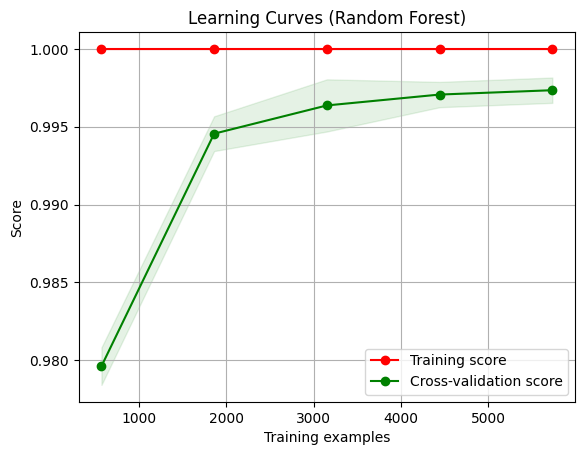

In [35]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# 学習曲線を作成する関数を定義
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# 学習曲線をプロット
title = "Learning Curves (Random Forest)"
plot_learning_curve(rf_model, title, X, y, cv=5)
plt.show()


    以下はベストなハイパーパラメーターを探すため、RandomizedSearchCVのライブラリを利用してみる。

In [38]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# ランダムフォレスト分類器のハイパーパラメータ範囲を定義
param_distributions = {
    'n_estimators': [400, 500, 600, 700],
    'max_depth': [8, 9, 10, 11],
    'min_samples_split': [8, 10, 12],
    'min_samples_leaf': [1, 2, 3]
}

# RandomizedSearchCVの初期化
random_search = RandomizedSearchCV(
    RandomForestClassifier(),
    param_distributions=param_distributions,
    n_iter=100,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# ハイパーパラメータのチューニングとモデルの訓練
random_search.fit(X_train_upsampled, y_train_upsampled)

# ベストモデルを取得
best_model = random_search.best_estimator_

# テストデータでの予測
y_pred = best_model.predict(X_test)

# 正確さ（Accuracy）とF1スコアの計算
accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

# 結果の表示
print("最適なハイパーパラメータ:", random_search.best_params_)
print("正確さ（Accuracy）:", accuracy)
print("F1スコア（Macro）:", macro_f1)
print("F1スコア（Weighted）:", weighted_f1)
print(f'MCC: {mcc}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
最適なハイパーパラメータ: {'n_estimators': 500, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_depth': 11}
正確さ（Accuracy）: 0.9990697674418605
F1スコア（Macro）: 0.9974371872474437
F1スコア（Weighted）: 0.9990716702159799
MCC: 0.9948874555978666
